## Part 2: A SEIR cellular automata model:

### Table of Contents  <a name="index"></a>
  * [01.Conceptual Model Introduction](#01)
  * [02.Tutorial](#02)
      - [02.1 CA framework utilities](#021)
      - [02.2 Simulation utilities](#022)
      - [02.3 Simulate Example one run](#023)
      - [02.4 Simulate Example multiple runs](#024)
  * [03. Real Data Acquisition, Processing](#03)
      - [03.1 Data Source](#031)
      - [03.2 Data Used](#032)
      - [03.3 Data Processing, Insights, Basic Statistics](#033)
  * [04. Validation](#04)
      - [04.1 Comparison with the Simulated Data](#041)
  * [05. Visualizations](#05)

### 1. Disease Spread Model: Modified SEIR with cellular automata framework <a name="01"></a>

An analysis of COVID-19 publicly reported confirmed cases in the early stage of the pandemic, from [Lauer SA et al.](https://annals.org/AIM/FULLARTICLE/2762808/INCUBATION-PERIOD-CORONAVIRUS-DISEASE-2019-COVID-19-FROM-PUBLICLY-REPORTED)[1], estimated that that COVID-19 has a mean incubation period approximately of 5 days, and 97.5 percent of people will develop symptons within 11.5 days of infection.<br>
The incubation period is the time between exposure to the disease and starting to show symptoms. It is usually considered before the contagious period, when infected individual can transmit the virus to others. However, there are cases reported by [Rothe, C. et al.](https://doi.org/10.1056/NEJMc2001468) [2] showing that asymptomatic persons are potential sources of 2019-nCoV infection, which means the COVID-19 could be contagious even during the late stage of incubation period. Research by [Zou, Lirong, et al.](https://www.nejm.org/doi/full/10.1056/NEJMc2001737)[3] on viral load of asymptomatic infected patients also support this, and warrants a reassessment of transmission dynamics of the current outbreak. <br>
In this simulation, a SEIR model (Susceptible, Exposed, Infectious, Recovered) was selected to describe the spread of COVID-19. Compared to the SIR model, an "Exposed" population category was added to describe the infected population during the incubation period. However, as the study suggested, it is unknown yet how large in scale can the infected people during the incubation period be infectious. To address this concern, an extra probability layer with a tunable variable was added to decribe how soon people in "E" become "I". And we assume the recovered individual will have total immune to the COVID-19.

THE **SEIR**  system can be described as below:
1. $N=S+E+I+R$ :

> where N is the total number of population, S is the susceptible, E is the exposed, I is the infected, R is the recovered or deaths. Here the R inclues death population, because death also stops the spread of virus, which has similar impact to the model like recovered with total immune. 


2. **Modified SEIR** : <br>
As the study suggested, it is unknown yet how large in scale can the people during the incubation period (Status: EXPOSED) be infectious yet showing no symptoms. To address this concern, an ***extra probability layer with a tunable variable*** was added to describe how soon and how much of people in "E" could become "I", and how people in "E" could affect neighbors become "E" in a similar fashion like people in "I" behave. And an assumption made that the recovered individual will have total immune to the COVID-19. Thus, a modified SEIR model addressing the asymptoms virus shedding was created. 

![phasechange](https://github.gatech.edu/raw/mguo34/COVID-19-Simulation/master/README_figs/phasechange.png?token=AAAHWIFW4MHPJ7QP4BSRBXK6WGSSQ)


3. **Infectious Pattern** of Modified SEIR model in CA framework: <br>
A cellular Automata method was applied, to model the spread, putting one person in each grid cell of a $n \times n$ matrix, the four surrounding neighbor cells representing the persons in close contact. Each person has {S,I,E,R} four possible states. 


![infectiouspattern](https://github.gatech.edu/raw/mguo34/COVID-19-Simulation/master/README_figs/infectiouspattern.png?token=AAAHWIFN2YLF56O7P6E22PK6WGS6E)

##### Reference:
[1] Lauer SA, Grantz KH, Bi Q, et al. The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application. Ann Intern Med. 2020; [Epub ahead of print 10 March 2020]. doi: https://doi.org/10.7326/M20-0504

[2] Rothe, C. et al. Transmission of 2019-nCoV infection from an asymptomatic contact in germany. N. Engl. J. Med. https://doi.org/10.1056/NEJMc2001468 (2020).

[3] Zou, Lirong, et al. "SARS-CoV-2 viral load in upper respiratory specimens of infected patients." New England Journal of Medicine 382.12 (2020): 1177-1179.



### 2. Tutorial - Build the CA framework modified SEIR model <a name="02"></a>

#### 2.1 CA framework utilities <a name="021"></a>

For the celluar automata model, each cell within the NxN grid represents a person. Each person could have one of the S,E,I,R status. 

When creating the NxN grid framework, we denote an outer boundary outside the framework, using EMPTY, value -1 to represent.

For all the cells within the boundary are the total populations. For example, for N = 100, a 100 x 100 grid will represent a population of 10000 people. For each person, we define the up, down, left, right side connecting cells as close contact neighbors. The neighbor cells are the cells that could be affected by the person's status. 

Based on our literature review, and some trials, we estimate the transition probability for status transition.
We also set a days count limit as the upper bound especially for EXPOSED and INFECTIOUS status. Meaning that if for 14 consecutive days being EXPOSED, at 15th day, the person will either be recovered or showing syptoms (classified as INFECTIOUS). But it is worth to notice that INFECTIOUS status meaning showing syptoms and can be infectious. Before a person become INFECTIOUS, the person can also be infectious when the person is in EXPOSED status. This is the main extension part of this SEIR model. 

For people becoming INFECTIOUS, the day count for this person will start counting the days he/she is being INFECTIOUS. The upper limit for being INFECTIOUS is set to be 28 days, meaning after 28 days in INFECTIOUS status, a person can either be dead or fully recovered, both are classified as RECOVERED in the model.

We use this days counting thresh method to prevent people staying at 1 status forever, this could happen because we use generate random probability for each person each day. And at the same time, this days threshold method can describe the asyptoms and syptoms infections. Asytoms typically have less days to recover, but can be infectious for the first 14 days. Syptoms can be infectious during the EXPOSED period, but can also be infectious when showing syptoms becoming INFECTIOUS period. The day count thresh method can effectively find out which cell should change phase, which may continue.

For a general concern, we place the "patient zero" at the very center of the population.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### CA framework utilities
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

### Probability Setting
PROB_Exposure = 0.90 #conditional probability of getting sick, given any sick neighbors
PROB_Exposure2Recovered = 0.8
PROB_Exposure2Infectious = 1- PROB_Exposure2Recovered

### Days counter threshold
E_time_thresh = 14 # days
I_time_thresh = 28 # days

### random seed (for debugging purpose)
np.random.seed (1602034230) # 


PROB_Recover = 0.96

def count (G):
    """
    Counts the number of locations in a NumPy array, `G`,
    where `np.where (G)` holds.
    """
    return len (np.where (G)[0])

def find (G):
    """
    Returns the set of locations of a NumPy array, `G`,
    where `np.where (G)` holds.
    """
    assert type (G) is np.ndarray
    return {(i, j) for i, j in zip (*np.where (G))}



#### Initial a world of nxn grid, each box contain one people. Initially dropped an infected one in the center of the crowd.
def create_world(n):
    G = EMPTY * np.ones ((n+2, n+2), dtype=int)
    G[1:-1, 1:-1] = SUSCEPTIBLE
    i_mid = int ((n+2)/2)
    #All except the middle person is susceptible
    G[i_mid, i_mid] = INFECTED
    return G


def plot_initial (G, vmin=EMPTY, vmax=RECOVERED, values="states"):
    """A helper routine to visualize a 2-D world."""
    # Set color range
    assert values in ["states", "bool"]
    if values == "states":
        vticks = range (vmin, vmax+1)
        vlabels = ['Empty', 'Susceptible','Exposed','Infected','Recovered']
    else:
        vticks = [0, 1]
        vlabels = ['False (0)', 'True (1)']
    
    m, n = G.shape[0]-2, G.shape[1]-2
    plt.pcolor (G, vmin=vmin, vmax=vmax, edgecolor='black')
    cb = plt.colorbar ()
    cb.set_ticks (vticks)
    cb.set_ticklabels (vlabels)
    plt.axis ('square')
    plt.axis ([0, m+2, 0, n+2])
    return

## detect functions
def susceptible (G):
    return (G == SUSCEPTIBLE).astype (int)


def infected (G):
    return (G==INFECTED).astype (int)

def exposed (G):
    return (G==EXPOSED).astype (int)

def exposing_index (G):
    """
    Returns a grid whose (i, j) entry is 1 if it has
    at least 1 infected neighbor, or 0 otherwise.
    """
    E = np.zeros (G.shape, dtype=int) # exposed people
    ### BEGIN SOLUTION
    I = infected (G)+exposed(G)
    E[1:-1, 1:-1] = I[0:-2, 1:-1] | I[1:-1, 2:] | I[2:, 1:-1] | I[1:-1, 0:-2]
    ### END SOLUTION
    return E

# Visualizes your results:

def recovered (G):
    return (G==RECOVERED).astype (int)

def days_count_initial(G):
    ###
    D = np.zeros(G.shape,dtype = int)
    return D


# define a asymptoms matrix to identify whom will show no symptoms if exposed
def asymptoms_matrix(G,recover = PROB_Exposure2Recovered):
    random = np.random.uniform(size=G.shape)
    G_a = (random<recover)
    return G_a.astype(int)

def expired_day(G_asymptoms,E_time_thresh, I_time_thresh):
    # day count probability between 0-1
    random = np.random.uniform(size=G_asymptoms.shape)
    # return the day counts distribution for E could be I and E could be R 
    G_symptoms = np.round((G_asymptoms<1)*random*E_time_thresh)
    G_asymptoms = np.round(G_asymptoms*(random*(I_time_thresh)+E_time_thresh))
    G_days = G_symptoms+G_asymptoms
    return G_days

def recovered_day(G_asymptoms,E_time_thresh,I_time_thresh):
    random = np.random.uniform(size=G_asymptoms.shape)
    G_infect2recov = np.round((G_asymptoms<1)*random*I_time_thresh)
    return G_infect2recov


def spreads (G,G_asymptoms_index,G_days_change,G_infect2recov,D,tau=PROB_Exposure,theta=PROB_Recover, E_time = E_time_thresh, I_time=I_time_thresh):
    #### update counter, new iteration update now, all start at 0 at iteration = 0. existing E and I +=1.
    D_update = D+infected(G)+exposed(G)
    
    
    ### find the getting exposed surroundings of infected, including being exposed by I. 
    random_draw_s2e = np.random.uniform (size=G.shape)
    random_draw_i2r = np.random.uniform (size=G.shape)
    
    G_e = (susceptible (G) * exposing_index (G) * (random_draw_s2e < tau))
    # for the pecent that turned to I from E
    G_i = exposed(G)*(G_asymptoms_index<1)*(G_days_change==D_update)
    G_r_from_e = exposed(G)*G_asymptoms_index*(G_days_change==D_update)
    G_r_from_i = infected(G)*((G_infect2recov+G_days_change)==D_update)
    D_final =D_update - D_update*G_e
    
    G = G-G*(G_e+G_i+G_r_from_e+G_r_from_i)+G_e*EXPOSED+G_i*INFECTED+(G_r_from_e+G_r_from_i)*RECOVERED
    confirmed = np.sum(G_i)
    return G, D_final,confirmed




#### 2.2 Simulate over time steps (days) utilities functions <a name="022"></a>
In this block, two utilities functions are provided, one is to save each time step plot frame while getting the data, the other one is to get the data without plotting and saving figures.
The output figures are found at "ca_outputs" folder, we intentionaly ignored this outputs in our github repo, as they take up too much space, but they can be generated locally. 


In [2]:
def simulate_ca_modified_seir(max_iteration,initial_test,D):
    container = {"S":[],"E":[],"I":[],"R":[],"Confirmed":[]}
    container["S"].append(np.sum(susceptible(initial_test)))
    container["E"].append(np.sum(exposed(initial_test)))
    container["I"].append(np.sum(infected(initial_test)))
    container["R"].append(np.sum(recovered(initial_test)))
    container["Confirmed"].append(np.sum(infected(initial_test)))

    population = np.sum(container.values())
    for i in range(max_iteration):
        initial_test, D,confirmed = spreads(initial_test, G_asymptoms_index,G_days_change,G_infect2recov,D)
        container["S"].append(np.sum(susceptible(initial_test)))
        container["E"].append(np.sum(exposed(initial_test)))
        container["I"].append(np.sum(infected(initial_test)))
        recovered_total = np.sum(recovered(initial_test))
        container["R"].append(recovered_total)
        container["Confirmed"].append(confirmed)

        fig = plt.figure ()
        plot_initial(initial_test)
        plt.savefig('./ca_outputs/test_'+str(i)+'.png',dpi=600)
        if recovered_total == population:
            return initial_test, D,container
    return initial_test, D,container


def simulate_ca_modified_seir_without_saving_plots(max_iteration,initial_test,D):
    container = {"S":[],"E":[],"I":[],"R":[],"Confirmed":[]}
    container["S"].append(np.sum(susceptible(initial_test)))
    container["E"].append(np.sum(exposed(initial_test)))
    container["I"].append(np.sum(infected(initial_test)))
    container["R"].append(np.sum(recovered(initial_test)))
    container["Confirmed"].append(np.sum(infected(initial_test)))

    population = np.sum(container.values())
    for i in range(max_iteration):
        initial_test, D,confirmed = spreads(initial_test, G_asymptoms_index,G_days_change,G_infect2recov,D)
        container["S"].append(np.sum(susceptible(initial_test)))
        container["E"].append(np.sum(exposed(initial_test)))
        container["I"].append(np.sum(infected(initial_test)))
        recovered_total = np.sum(recovered(initial_test))
        container["R"].append(recovered_total)
        container["Confirmed"].append(confirmed)
        if recovered_total == population:
            return initial_test, D,container
    return initial_test, D,container



#### 2.3 Simulate one run, with 100x100 ca model, max iteration thresh at 30.  <a name="023"></a>
Due to the limit of the pages, I will use a 30 max iterations for 100x100 CA model. Normally a 100x100 will stop around 120 days when all people are recovered. Later section will explore that part further in a statistical way. 

/home/muyangguo/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


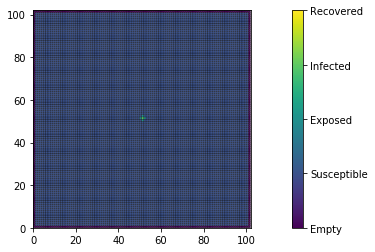

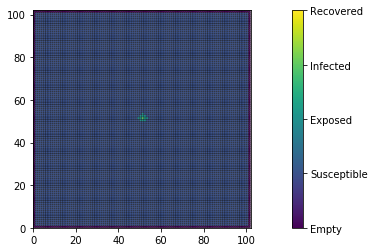

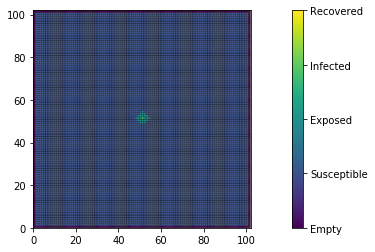

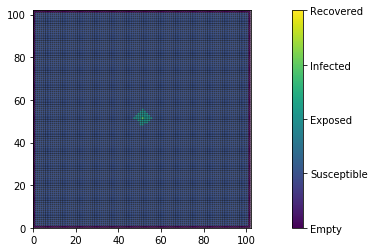

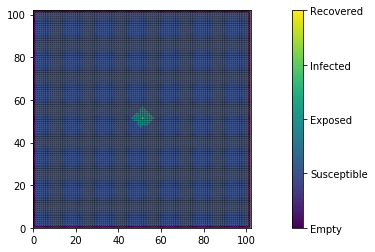

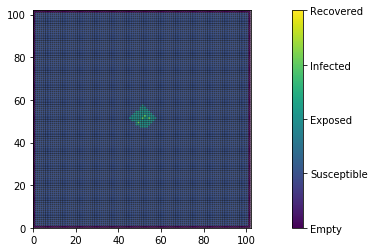

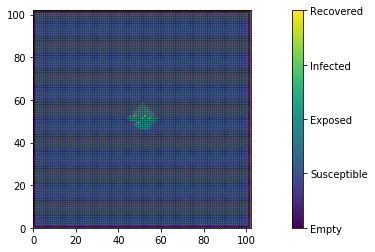

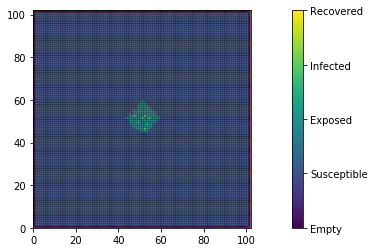

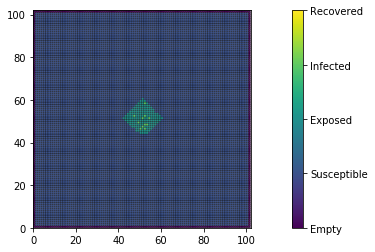

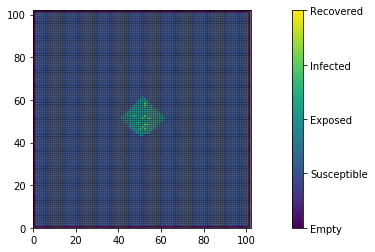

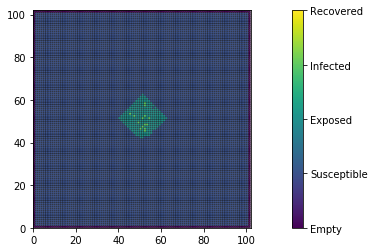

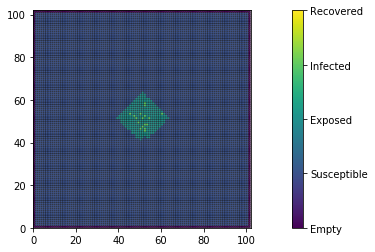

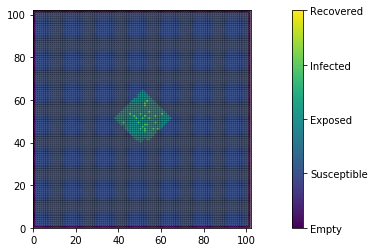

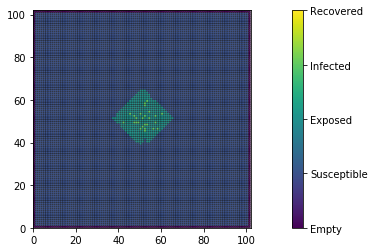

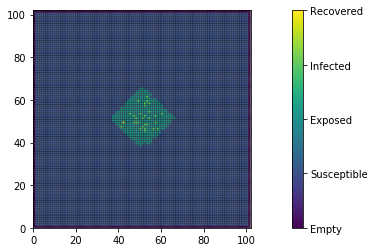

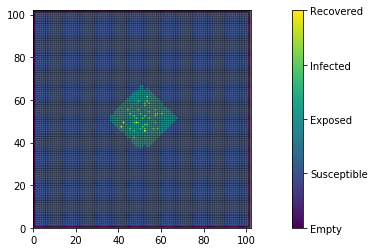

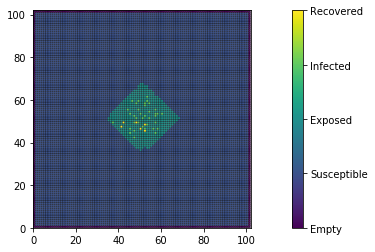

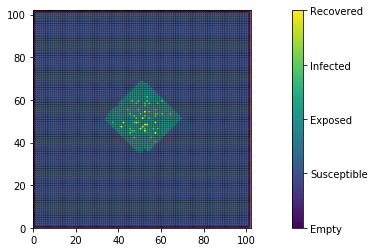

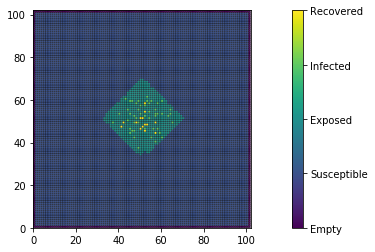

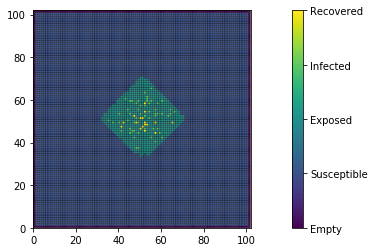

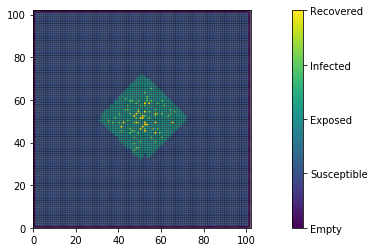

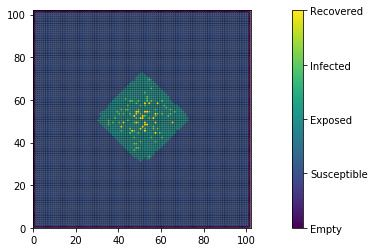

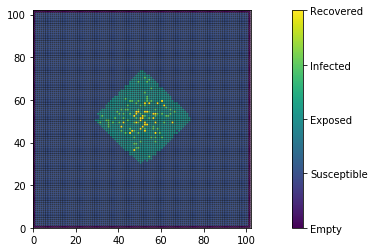

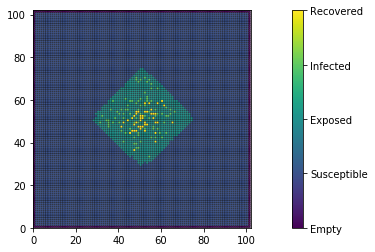

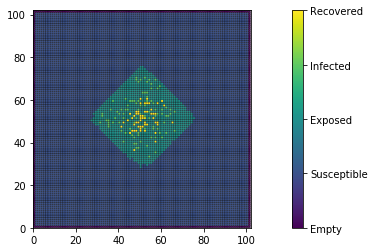

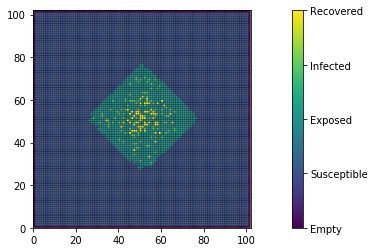

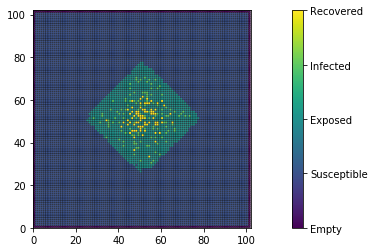

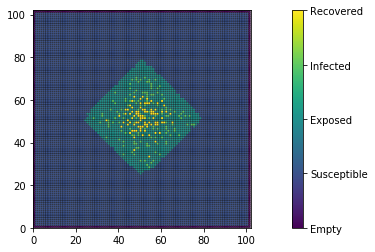

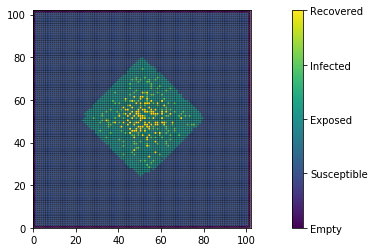

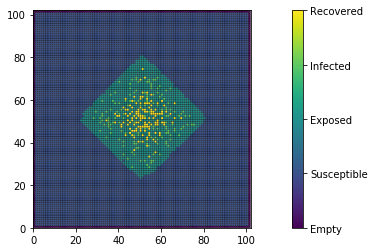

In [3]:
### Reclaim variables values setting for your convienience for later change.

### CA framework utilities
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

### Probability Setting
PROB_Exposure = 0.90 #conditional probability of getting sick, given any sick neighbors
PROB_Exposure2Recovered = 0.8
PROB_Exposure2Infectious = 1- PROB_Exposure2Recovered

### Days counter threshold
E_time_thresh = 14 # days
I_time_thresh = 28 # days

### random seed (for debugging purpose)
np.random.seed (1602034230) # 


PROB_Recover = 0.96


### N describe the population, NxN is the total population in CA framework,
### MAX_iteration holds the thresh iteration times to stop the simulation 
N = 100
MAX_iteration = 30

scale_test = create_world (N)
# plot_initial (scale_test)
D_counter = days_count_initial(scale_test)
G_asymptoms_index = asymptoms_matrix(scale_test)
G_days_change = expired_day(G_asymptoms_index, E_time_thresh,I_time_thresh)
G_infect2recov = recovered_day(G_asymptoms_index,E_time_thresh,I_time_thresh)

result_test, counter,container = simulate_ca_modified_seir(MAX_iteration,scale_test,D_counter)

#### 2.4 Simulate multiple runs, with 100x100 ca model, max iteration thresh at 100.  <a name="024"></a>
Depending on memoty limitation, multiple runs with large ca can be time consuming. In this example, we run 20 times and average the results of total runs. To save time and memory, we use the simulate function without savign figures for each frame.
The parameters setting inheritaged from the previous single run trial.
The data of the SEIR daily count averaged are plotted over time.  

This time, we chose a MAX_Iteration of 180 days, in order to see how many days for the population to become fully recovered, and what will be the peak percentage, and when will that happen.

Initilized with run 0
('Done run time: ', 1)
('Done run time: ', 2)
('Done run time: ', 3)
('Done run time: ', 4)
('Done run time: ', 5)
('Done run time: ', 6)
('Done run time: ', 7)
('Done run time: ', 8)
('Done run time: ', 9)
('Done run time: ', 10)
('Done run time: ', 11)
('Done run time: ', 12)
('Done run time: ', 13)
('Done run time: ', 14)
('Done run time: ', 15)
('Done run time: ', 16)
('Done run time: ', 17)
('Done run time: ', 18)
('Done run time: ', 19)


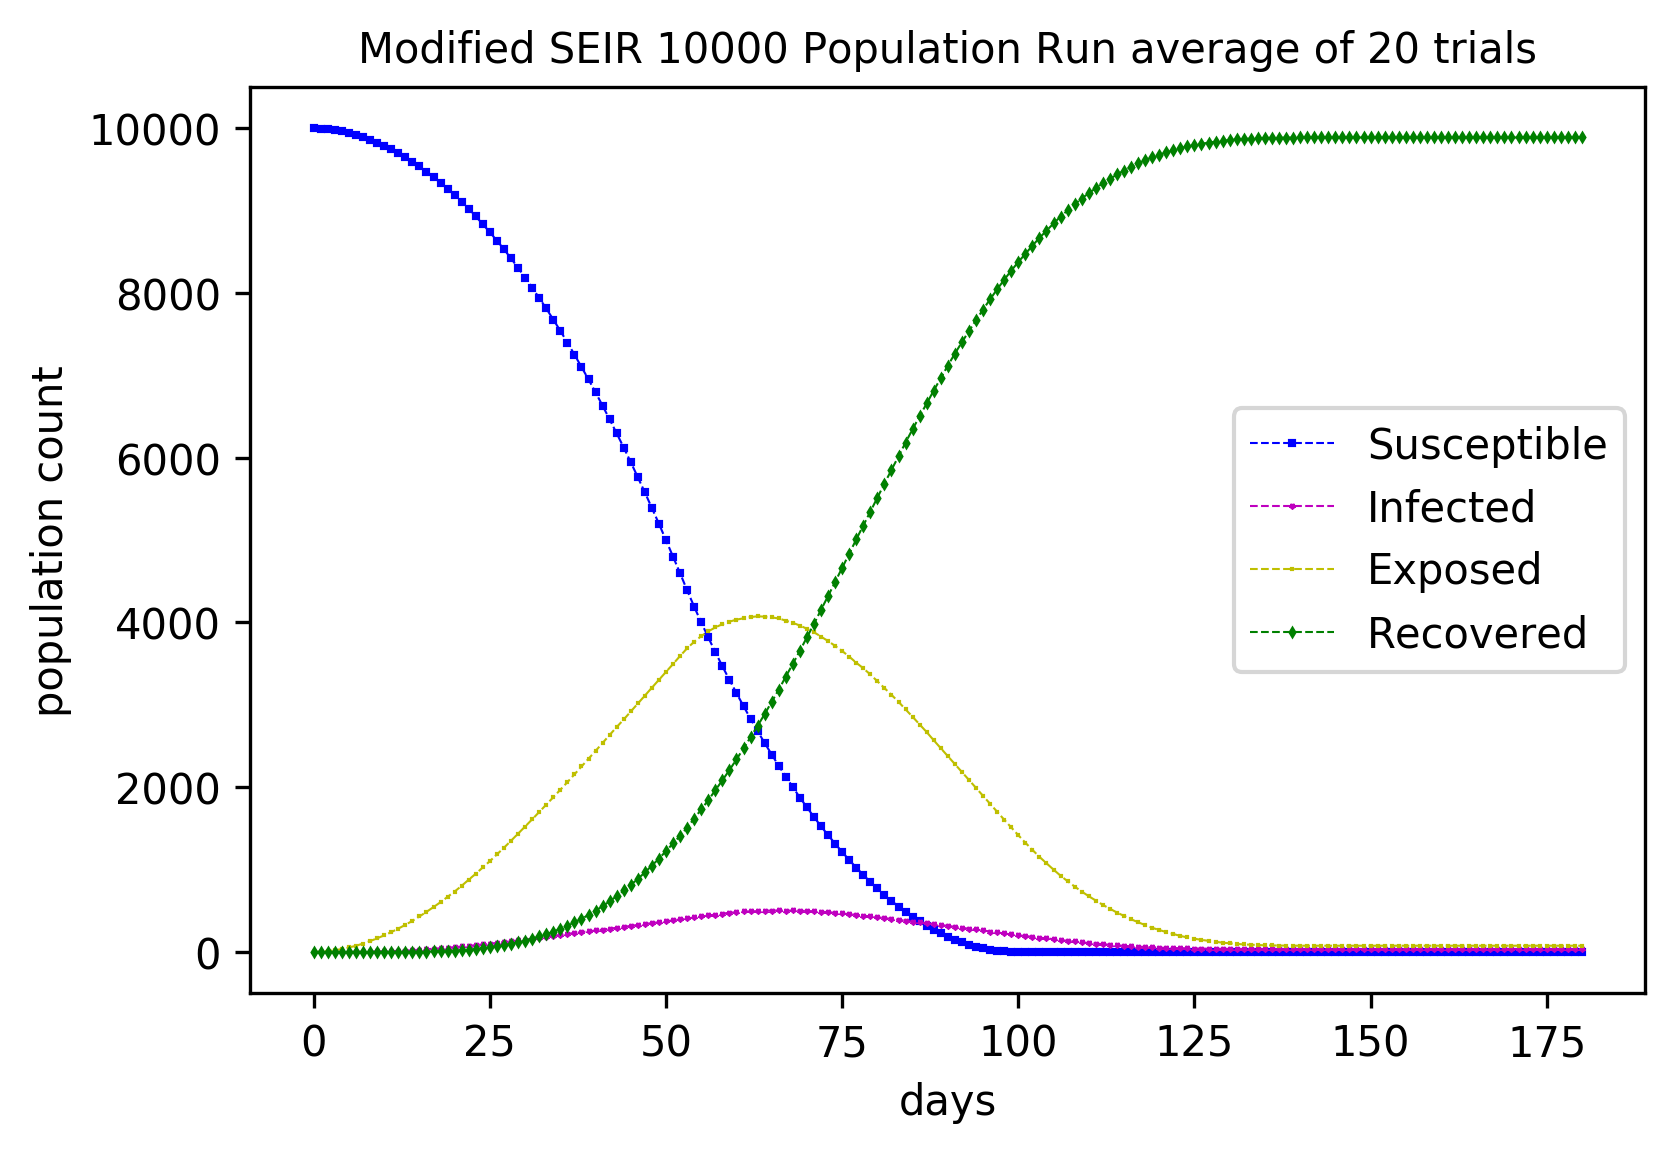

In [4]:
#### RUN Multiple times and Plot average 


RUN_TIMES = 20
N = 100
MAX_iteration = 180

container = {"S":[],"E":[],"I":[],"R":[],"Confirmed":[]}
for i in range(RUN_TIMES): 

    scale_test = create_world (N)
    single_container = {"S":[],"E":[],"I":[],"R":[],"Confirmed":[]}
    single_container["S"].append(np.sum(susceptible(scale_test)))
    single_container["E"].append(np.sum(exposed(scale_test)))
    single_container["I"].append(np.sum(infected(scale_test)))
    single_container["R"].append(np.sum(recovered(scale_test)))
    single_container["Confirmed"].append(np.sum(infected(scale_test)))

    D_counter = days_count_initial(scale_test)
    G_asymptoms_index = asymptoms_matrix(scale_test)
    G_days_change = expired_day(G_asymptoms_index, E_time_thresh,I_time_thresh)
    G_infect2recov = recovered_day(G_asymptoms_index,E_time_thresh,I_time_thresh)

    result_test, counter,single_container = simulate_ca_modified_seir_without_saving_plots(MAX_iteration,scale_test,D_counter)
    if i == 0:
        container = single_container
        print("Initilized with run 0")
    else:
        container["S"] = [a + b for a, b in zip(container["S"],single_container["S"])]

        container["E"] = [a + b for a, b in zip(container["E"],single_container["E"])]
        container["I"] = [a + b for a, b in zip(container["I"],single_container["I"])]
        container["R"] = [a + b for a, b in zip(container["R"],single_container["R"])]
        container["Confirmed"] =[a + b for a, b in zip(container["Confirmed"],single_container["Confirmed"])]
        print("Done run time: ", i)
        
        
#### Plot the averaged data
        
container["S"] = [a/RUN_TIMES for a in container["S"]]
container["E"] = [a/RUN_TIMES for a in container["E"]]
container["I"] = [a/RUN_TIMES for a in container["I"]]
container["R"] = [a/RUN_TIMES for a in container["R"]]
container["Confirmed"] = [a/RUN_TIMES for a in container["Confirmed"]]


S = container["S"]
I = container["I"]
E = container["E"]
R = container["R"]
Confirmed = container["Confirmed"]

# function to find cumulative sum of array 


def cumulativeSum(input): 
    output = []
    for i in range(len(input)):
        prefixsum = sum(input[0:i+1])
        output.append(prefixsum)
    return output


Confirmed = cumulativeSum(Confirmed)

fig, ax = plt.subplots( dpi = 300)
ax.plot(range(len(S)),S,'bs--', label='Susceptible' ,linewidth=0.5,markersize=1)
ax.plot(range(len(S)),I,'m*--', label='Infected',linewidth=0.5,markersize=1)
ax.plot(range(len(S)),E,'y+--', label='Exposed',linewidth=0.5,markersize=1)
ax.plot(range(len(S)),R,'gd--', label='Recovered',linewidth=0.5,markersize=1)
ax.set_title("Modified SEIR 10000 Population Run average of "+str(RUN_TIMES)+" trials",fontsize = 10)
plt.xlabel('days', fontsize=10)
plt.ylabel('population count', fontsize=10)


# ax.plot(range(len(S)),Confirmed,'r', label='Confirmed Cases')
ax.legend()
        
    
    


#### Discussion

As can been seen from the plot, the model with the current setting predict that around 120 days, all population will be in RECOVERED status. The Peak EXPOSURE percentage will happen at around 60 days. And the EXPOSED rate could be as high as 40% at that peak. The Infected peak is also at that time. The EXPOSED cases are more than the INFECTED cases, this is because we have considered the asymptoms populations. They did not show any symptoms yet could be infectious as well. And we can see RECOVERED population soon become larger than the INFECTED cases, it is because so many people are EXPOSED but being asyptoms and over some days they become RECOVERED directly. Only a fraction of the EXPOSED actually showed syptoms and become INFECTED status. 
This plot fits all of our expectations. 

### 3. Real Data Acquisitions, Processing, Validating <a name="03"></a>
In this section, we will first pull the latest public data, and gain a general understanding of the real data curves, with some basic statistics. We will most use the national death rate to estimate our death rate in our projection model. 
We also will use real data to align with our scaled projection data. For example, the CA model we use predict a 10000 population outbreak. If scaled to a NEW YORK population level, at about 8.623 million people, we need to scale our projection for 862.3 times. Thus the first and only one infected person at day 0 in the CA frame will be scaled to 862 people. Then we tried to find the a day from NEW YORK 's accumulated daily confirmed cases data around that 862 number, and align our projection's starting date as that date. 

#### 3.1 Data Source:  <a name="031"></a>
Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)
- [Blog](https://systems.jhu.edu/research/public-health/ncov/)
- [Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)

#### 3.2 Data used: <a name="032"></a>
[CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)
    1. time_series_covid19_confirmed_US.csv
    3. time_series_covid19_deaths_US.csv

    
    

#### 3.3 Data Pre-processing, basic statistics and insights: <a name="033"></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def preprocess_US(data_url):
    df = pd.read_csv(data_url)
    last_update_date = df.keys()[-1]
    df.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Lat','Long_'], axis = 1, inplace = True)
    df_cleaned= df.groupby(['Province_State'], as_index = False).sum()
    df_sorted = df_cleaned.sort_values(by=last_update_date,ascending=False).reset_index(drop=True)
    update_total = sum(df_sorted[last_update_date])
    return df_sorted, last_update_date, update_total


In [6]:
### Retrieve data from CSSEGISandData Github Raw content in csv
url_confirmed_US = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
url_deaths_US = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'



### Get useful insights of the updated data (data is updated daily)
df_confirmed_US,last_confirmed_US,total_confirmed_US = preprocess_US(url_confirmed_US)
df_deaths_US,last_deaths_US,total_deaths_US = preprocess_US(url_deaths_US)
first_date_US = df_confirmed_US.keys()[1]
print("Data Basic Statistics: \n")
print('From {} till {} the US confirmed cases total is : {} \n'.format(first_date_US,last_confirmed_US,total_confirmed_US))
print('From {} till {} the US deaths cases total is : {} \n'.format(first_date_US,last_deaths_US,total_deaths_US))
mortality_rate = float(total_deaths_US)/float(total_confirmed_US)*100
print('Mortality rate in US is being updated as {:.3f}% \n'.format(mortality_rate))
US_population_list = df_deaths_US['Population']
US_population = US_population_list.sum()
df_deaths_US.drop(['Population'], axis = 1, inplace = True)
print('COVID-19 is among US population of {:.5f}% and fatal rate is {:.5f}% \n'.format(float(total_confirmed_US)/float(US_population)*100, float(total_deaths_US)/float(US_population)*100))

Data Basic Statistics: 

From 1/22/20 till 4/27/20 the US confirmed cases total is : 988197 

From 1/22/20 till 4/27/20 the US deaths cases total is : 56259 

Mortality rate in US is being updated as 5.693% 

COVID-19 is among US population of 0.29391% and fatal rate is 0.01673% 



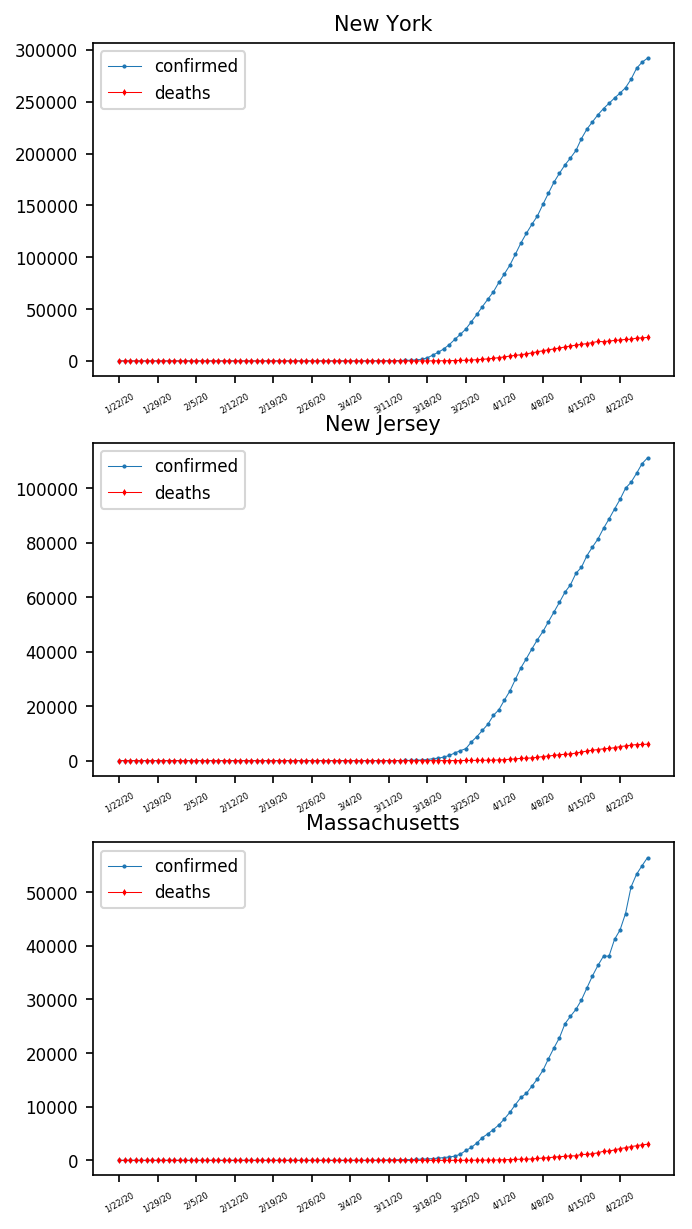

In [12]:
### Plot the top severe states daily increasing cases and death plots

def get_top_rank(sorted_df,compare_df,rank):
    # Create an empty list
    container = {}
    rows_list = []
    rows_compare_list=[]
    state_sorted_order = []
    # Iterate over each row 
    for index, row in sorted_df.iterrows():
        if index <rank:
            row_list = row.to_list()
            container[row_list[0]] = [row_list[1:]]
            state_sorted_order.append(row_list[0])
    for index_compare, row_compare in compare_df.iterrows():
        row_compare_list = row_compare.to_list()
        if row_compare_list[0] in container:
            container[row_compare_list[0]].append(row_compare_list[1:])
    return container, state_sorted_order
        
    
### Let us plot the top 3 severe states to have a general idea of the situation
container, state_list = get_top_rank(df_confirmed_US,df_deaths_US,3)
fig, ax = plt.subplots(ncols = 1, nrows = len(state_list), figsize = (5,10), dpi = 150)
date = df_confirmed_US.keys()[1:]

for i in range(len(state_list)):
    ax[i].plot(date,container[state_list[i]][0],'o-',label="confirmed", linewidth=0.5,markersize=1)
    ax[i].plot(date,container[state_list[i]][1],'rd-',label= "deaths", linewidth=0.5,markersize=1)
    ax[i].set_title(state_list[i],fontsize = 10)
    ax[i].tick_params(axis='x',labelsize=4)
    ax[i].tick_params(axis='y',labelsize=8)
    ax[i].legend(fontsize = 8)
    ax[i].set_xticks(date[::7])
    ax[i].set_xticklabels(date[::7], rotation=30)


## 4 Validation <a name="04"></a>
#### 4.1 Compairison between selected REAL data and Simulated data <a name="041"></a>
In this practice, we could used the averaged simulated data after multiple runs, previously stored in the "container" DICT, to compare with the real world data. 
The real data we selected is the NEW YORK accumulated confirmed data, and the Death data. 
The whole country scaled morality rate, is the DEATH_RATE that we used to predict the deaths from our SEIR model, since the SEIR model we had does not specifically indicate the DEATH portion.


Text(0.5,0,'date')

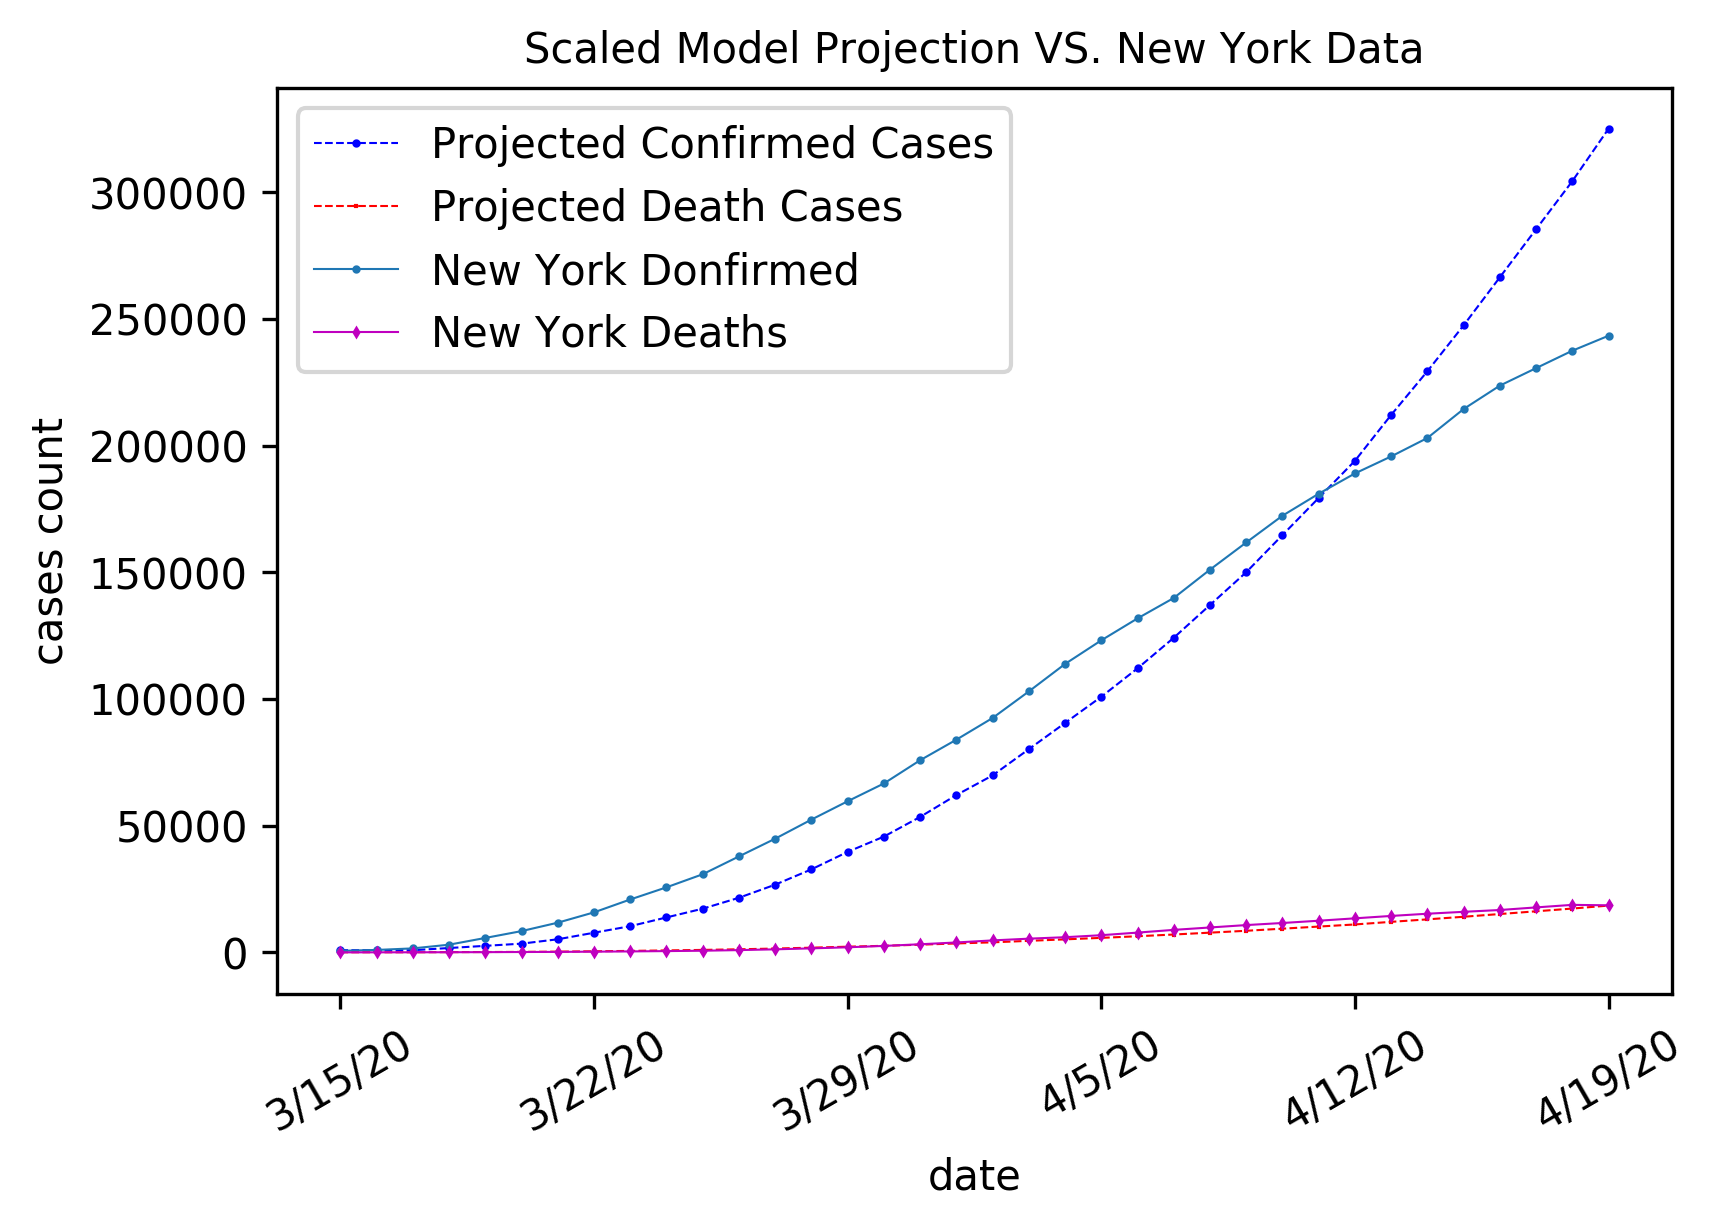

In [8]:
### Example Pick New York States as an example, New York is known to have 8.623 million people, and we could use 
### a daily updated retrieved morality rate as 5.683% (April 27th)

POPULATION = 862.3
DEATH_RATE = 0.05683


fig2, ax2 = plt.subplots( dpi = 300)
ax2.plot(range(len(Confirmed[4:40])),[POPULATION
*x for x in Confirmed[4:40]],'bo--',label='Projected Confirmed Cases',linewidth=0.5,markersize=1)

Death = np.round([862.3
*float(i)*DEATH_RATE for i in Confirmed[4:40] ])
ax2.plot(range(len(Death)),Death,'r+--',label='Projected Death Cases',linewidth=0.5,markersize=1)

container_top1, state_list_top1 = get_top_rank(df_confirmed_US,df_deaths_US,1)

check_len = len(Death)

date_ny = df_confirmed_US.keys()[1:]

date_ny = date_ny[53:(53+(check_len))]

Newyork_confirmed = container_top1["New York"][0][53:(53+(check_len))]
Newyork_death = container_top1["New York"][1][53:(53+(check_len))]
ax2.plot(date_ny,Newyork_confirmed,'o-',label="New York Donfirmed", linewidth=0.5,markersize=1)
ax2.plot(date_ny,Newyork_death,'md-',label= "New York Deaths", linewidth=0.5,markersize=1)
ax2.set_xticks(date_ny[::7])
ax2.set_xticklabels(date_ny[::7], rotation=30)
ax2.legend()
ax2.set_title("Scaled Model Projection VS. New York Data",fontsize = 10)
plt.ylabel('cases count', fontsize=10)
plt.xlabel('date', fontsize=10)




#### Discussion
As can be seen from the plots, after the scaling, and aligning the projection data with NEW YOPK's real data. The projected death curve and the NEW YORK death curve aligned well, and there is some difference between the projected confirmed cases, and confirmed cases. Our syptoms INFECTED curve seemed more steep than the real data, this could be due to the fact NEW YORK has taken measures to intervene the spread, yet our model does not count the intervene measures into consideration.

However,as our model has taken into account of the fact that the asyptoms people can infect others (assuming EXPOSED 80% could be asyptoms). There are days at the first 30 days that our projected infected data is below the real infected data curve, implying the fact that there should exist a quite large number of people being exposed yet not showing syptoms and just become recovered over some days in real world. 

## 5 Visualization (Due to the HTML content, the gif animation might not be able to be shown on pdf report, please go to github repo, or open the jupyter notebook) <a name="05"></a>

In this case, we showed some of animations for single trials. We stored the frames plot locally but not included in the github repo, so here are some processed animations as visualizations.

Clearly we could see that the EXPOSED status spread very quickly, but not all of the EXPOSED people become a confirmed case -- INFECTED status. Those without any symptoms will just become RECOVERED.


In [9]:
from IPython.display import HTML
HTML('<img src="ca_visuals/ca-modified-SEIR-10000.gif">')

In [10]:
HTML('<img src="ca_visuals/ca-modified-SEIR-10000-version2.gif">')